## TODOS:
1. [x] Add a sine as an input signal and compare the reconstructions in the different methods : Time,Freq domains and squared error
2. [x] Try correlating the two signals
3. [x] Read up a bit more on correlation

## Notes:
1. [x] Import audio and normalize it 
2. [x] Basic Test : Have the whole signal as stft and istft output using torch.stft()
3. [x] Simulating realtime overlap and add for COMPLETE FRAMES
4. [x] Simulating realtime overlap and add for Real time output of StrideLength(32 samples)

In [3]:
import torchaudio
import torch
import sounddevice as sd
import IPython.display as ipd
import numpy as np
from pesq import pesq
import matplotlib.pyplot as plt
from pystoi import stoi


import torch
import torch.fft as fft
from scipy.signal import correlate

import librosa
import librosa.display
from scipy.signal.windows import hann

### # <font color="green">Helper functions</font>

In [4]:
print(f'torchaudio backend : {torchaudio.get_audio_backend()}')

def minMaxNorm(wav, eps=1e-8):
    max = np.max(abs(wav))
    min = np.min(abs(wav))
    wav = (wav - min) / (max - min + eps)
    return wav

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

def printQualityScores(waveform_clean_clip,waveform_noisy_clip, sample_rate):
    pesq_score_test = pesq(sample_rate, waveform_clean_clip, waveform_clean_clip, 'nb')
    pesq_score_noisy = pesq(sample_rate, waveform_clean_clip, waveform_noisy_clip, 'nb')

    stoi_score_test = stoi(waveform_clean_clip, waveform_clean_clip, sample_rate, extended=False)
    stoi_score_noisy = stoi(waveform_clean_clip,  waveform_noisy_clip, sample_rate, extended=False)

    print(f'PESQ score for clean (baseline) = {pesq_score_test}')
    print(f'PESQ score for noisy = {pesq_score_noisy}')
    print("---------------------------------------------------")
    print(f'STOI score for clean (baseline) = {stoi_score_test}')
    print(f'STOI score for noisy = {stoi_score_noisy}')


def compareTwoAudios(input,reconstructed,sampling_rate = 16000):
  
    time = np.arange(len(input))

    # Plot the original signal with transparency
    plt.figure(figsize=(12, 6))
    plt.plot(time, input, label='Original Signal', alpha=0.5)

    # Plot the reconstructed signal on top with transparency
    plt.plot(time, reconstructed, label='Reconstructed Signal', alpha=0.5)

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Comparison of Original and Reconstructed Signals in Time Domain')
    plt.legend()

    # Compute and plot the Fourier transforms
    input_fft = np.fft.fft(input)
    reconstructed_fft = np.fft.fft(reconstructed)
    freq = np.fft.fftfreq(len(input), 1 / sampling_rate)

    plt.figure(figsize=(8, 4))
    plt.subplot(2, 1, 1)
    plt.plot(freq, np.abs(input_fft), label='Original Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Fourier Transform of Original Signal')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(freq, np.abs(reconstructed_fft), label='Reconstructed Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Fourier Transform of Reconstructed Signal')
    plt.grid()
    plt.tight_layout()

    
    mse = (input - reconstructed) ** 2
    # Plot the correlation
    plt.figure(figsize=(8, 4))
    plt.plot(time, mse,color='red') 
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Square Error between Original and Reconstructed Signals')
    plt.grid()
    plt.show()

    # Calculate the cross-correlation
    correlation = np.correlate(input, reconstructed, mode='full')
    # Create a time array for the correlation
    time = np.arange(-len(input) + 1, len(input))

    # Plot the correlation
    plt.figure(figsize=(12, 6))
    plt.plot(time, correlation)
    plt.xlabel('Time Lag (s)')
    plt.ylabel('Correlation')
    plt.title('Cross-Correlation between Original and Reconstructed Signals')
    plt.grid()
    plt.show()
    

torchaudio backend : sox_io


### # <font color="red">Audio loading</font>

In [5]:
seconds = 4.5
waveform_test, sample_rate = torchaudio.load('dataset/y_train/19-198-0003.wav',normalize=True)

waveform_noisy, sample_rate = torchaudio.load('dataset/train/19-198-0003.wav',normalize=True)

print(f'Number of samples = {int(sample_rate*seconds)} ')
waveform_test_clip = waveform_test[0][:int(sample_rate*seconds)]
waveform_noisy_clip = waveform_noisy[0][:int(sample_rate*seconds)]

Number of samples = 72000 


In [6]:
print(f'waveform_test_clip shape = {waveform_test_clip.shape}')
print(f'Sample rate = {sample_rate}')
ipd.Audio(waveform_test_clip, rate=sample_rate)

waveform_test_clip shape = torch.Size([72000])
Sample rate = 16000


In [7]:
print(f'waveform_noisy_clip shape = {waveform_noisy_clip.shape}')
print(f'Sample rate = {sample_rate}')
ipd.Audio(waveform_noisy_clip, rate=sample_rate)

waveform_noisy_clip shape = torch.Size([72000])
Sample rate = 16000


In [8]:
printQualityScores(waveform_test_clip.numpy(),waveform_noisy_clip.numpy(), sample_rate)

PESQ score for clean (baseline) = 4.548638343811035
PESQ score for noisy = 1.4327553510665894
---------------------------------------------------
STOI score for clean (baseline) = 0.9999999999999998
STOI score for noisy = 0.6687881913384738


### # <font color="red">SetInputAudio</font>

In [9]:
#Using clean audio for now to see how much it degrades from this procedure

# Define parameters
frequencyOfSine = 100
duration = 3.0
sampling_rate = 16000

t = np.linspace(0.0,duration, int(duration * sampling_rate))
y = np.sin(2 * np.pi * frequencyOfSine * t)

# Plot the sine wave
# plt.figure(figsize=(10, 4))
# plt.plot(t, y)
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.title('Sine Wave')
# plt.grid()
# plt.show()

# inputAudio = torch.from_numpy(y).to(torch.float32)
# inputAudio = waveform_test_clip
inputAudio = torch.from_numpy(minMaxNorm(waveform_test_clip.numpy()))

print(f'inputAudio shape = {inputAudio.shape}')

inputAudio shape = torch.Size([72000])


### # <font color="red">Basic Test - using stft and istft functions from pytorch</font>
-   Take an STFT over the signal
    -   Frame size = 512
    -   Stride length = 32
    -   n_fft = 512
 <br>
-   Take iSTFT over the output spectrogram
-   Check results

-   <font color="pink"><b>The results show that it's almost perfect reconstruction for clean signal</b></font>


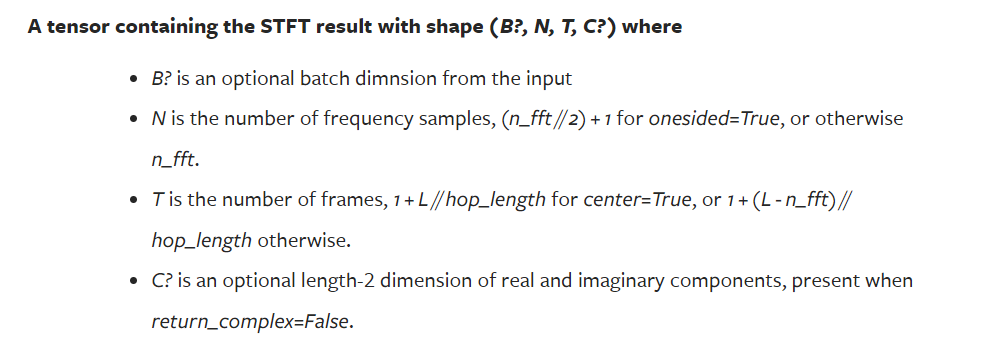

In [10]:
spectrogram = torch.stft(inputAudio, 
        n_fft=512, 
        hop_length=32, 
        win_length=512, 
        window=torch.hann_window(512), 
        center=True,
        return_complex=True)

print(f'spectrogram shape = {spectrogram.shape}')

reconstructedAudio = torch.istft(spectrogram,
                                 n_fft=512,
                                 hop_length=32,
                                 win_length=512,
                                 window=torch.hann_window(512),
                                      center=True,
                                            return_complex=False)


print(f'reconstructedAudio shape = {reconstructedAudio.shape}')

spectrogram shape = torch.Size([257, 2251])
reconstructedAudio shape = torch.Size([72000])


In [11]:
ipd.Audio(inputAudio, rate=sample_rate)

In [12]:
ipd.Audio(reconstructedAudio, rate=sample_rate)

PESQ score for clean (baseline) = 4.548638343811035
PESQ score for noisy = 4.548638343811035
---------------------------------------------------
STOI score for clean (baseline) = 0.9999999999999998
STOI score for noisy = 0.9999999999999857


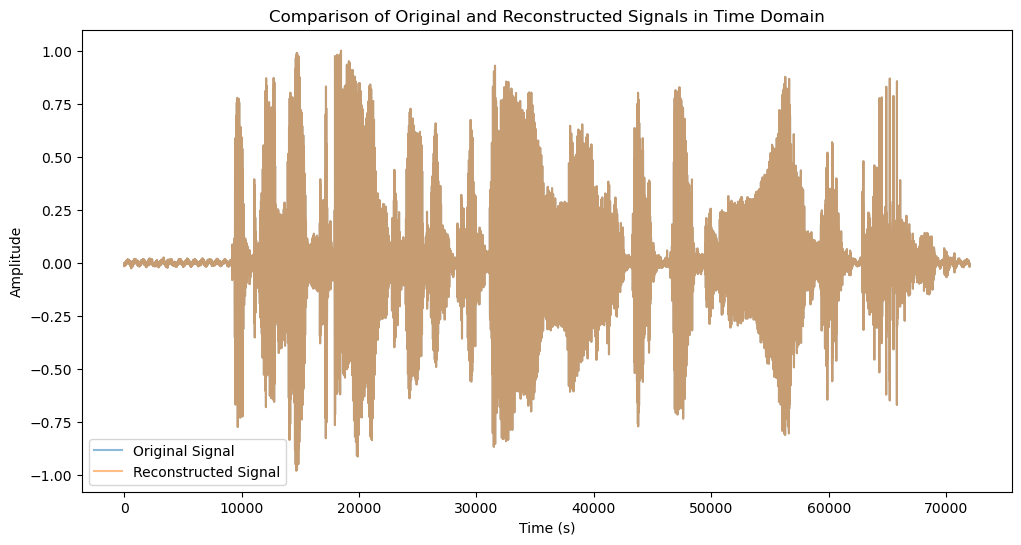

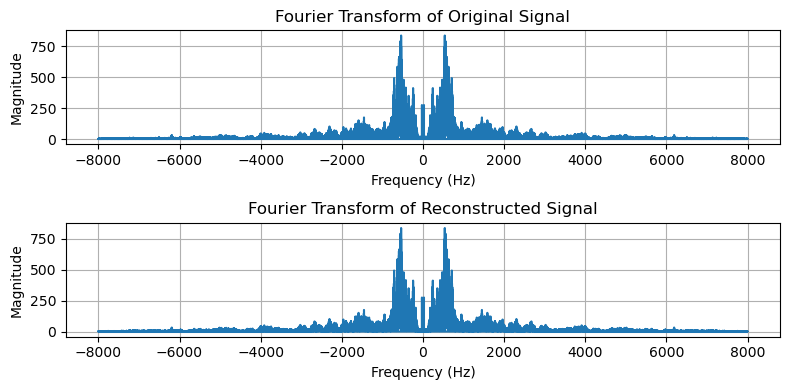

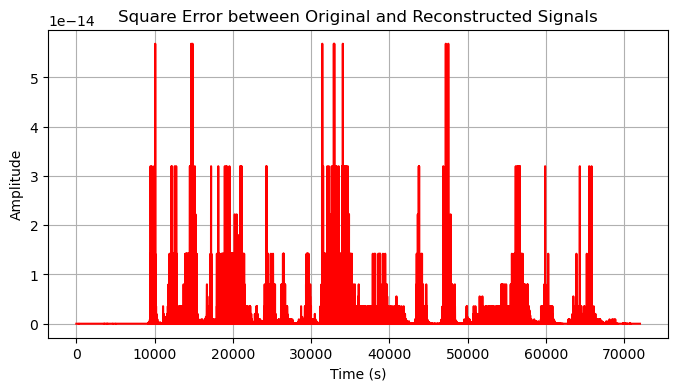

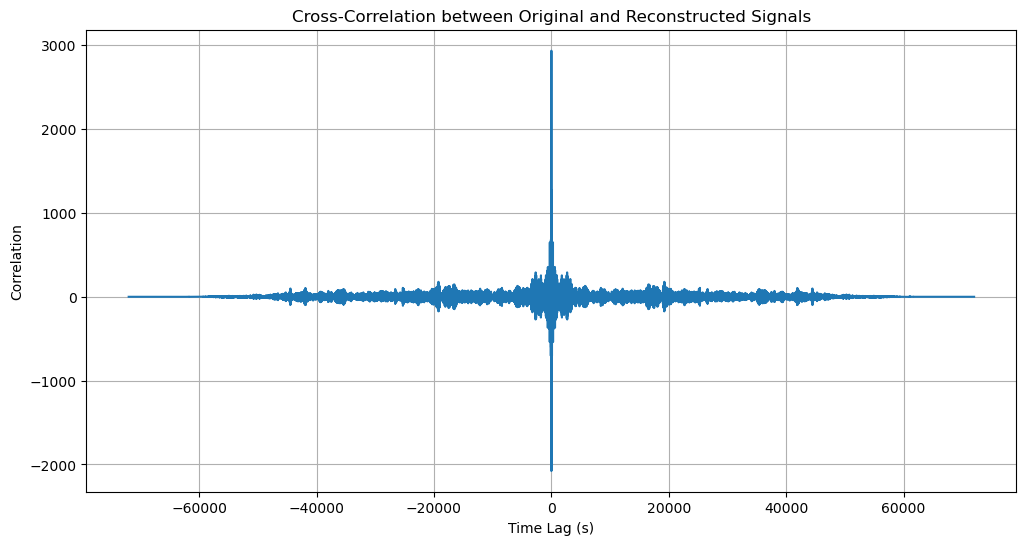

In [13]:
printQualityScores(inputAudio.numpy(),reconstructedAudio.numpy(), sample_rate)
compareTwoAudios(inputAudio,reconstructedAudio)

### # <font color="red">Simulating realtime Framing and taking ffts and iffts per frame and using overlap add to reconstruct the signal</font>

- Keeping an input buffer and then taking ffts as we slide the buffer
- FFT
    -   Frame size = 512
    -   Stride length = ?
    -   n_fft = 512
 <br>
- Take iFFT on the output spectrogram and keep in a list
- Figure out Overlap and add the frames together
- Check results

<font color="pink">
-   <b>The results show that it's almost perfect reconstruction for clean signal</b> <br>
-   With larger strides leading to better reconstruction quality [fixed stride]<br>
-   Better stoi for smaller frame sizes [fixed framesize] <br>
</font>

In [14]:
#512,256,128,64,32,16,8
frameSize = 512
stride_length = 32
# stride_length = 32
print(f'frameSize = {frameSize} corresponds to {frameSize/sample_rate*1000} ms')
print(f'stride_length = {stride_length} corresponds to {stride_length/sample_rate*1000} ms')

frameSize = 512 corresponds to 32.0 ms
stride_length = 32 corresponds to 2.0 ms


In [15]:
slidingBuffer = np.zeros((frameSize)).astype('float32')
overlap_percent = (1 - stride_length/frameSize)*100
print(f'Overlap percentage = {overlap_percent}%')

# List of frames generated (each frame is a tensor)
framesGenerated = []

for i in range(0, len(inputAudio),stride_length):
    # print(f'i = {i}')

    #inbuffer is moved : [__s1__+++++++++++++__s2__] -> [+++++++++++++__s2__]
    slidingBuffer[:-stride_length] = slidingBuffer[stride_length:] 

    #inbuffer is filled with new data: [+++++++++++++__s2__] -> [+++++++++++++----]
    slidingBuffer[-stride_length:] = inputAudio[i : i + stride_length]
    
    buffer_array = np.array(slidingBuffer)
    windowed_buffer = buffer_array * hann(len(buffer_array), sym=False)

    # Taking the real-valued FFT
    frame = np.fft.rfft(windowed_buffer)
    # print(f'frame shape = {frame.shape}')

    framesGenerated.append(frame)

print(f'inputAudio shape = {inputAudio.shape}')
print(f'xFrames (expectedFrames) = {len(inputAudio)//stride_length}') #Not (length - frameSize)/stride_length +1      
print(f'len(framesGenerated) = {len(framesGenerated)}')


Overlap percentage = 93.75%
inputAudio shape = torch.Size([72000])
xFrames (expectedFrames) = 2250
len(framesGenerated) = 2250


In [16]:
overlap_frames = 100 // overlap_percent - 1
print(f'Amount of future frames needed to calulate 1 frame = {overlap_frames}')

iFFTSignalSegments= []
#Taking iFFTs of frames
for frame in framesGenerated:
    segment = np.fft.irfft(frame)
    # print(f'segment shape = {segment.shape}')

    iFFTSignalSegments.append(segment)

print(f'len(iFFTSignalSegments) = {len(iFFTSignalSegments)}')
print(f'iFFTSignalSegments[0] shape = {iFFTSignalSegments[0].shape}')
print(f'iFFTSignalSegments[0][0].dtype = {iFFTSignalSegments[0][0].dtype}')

reconstructedAudio2 = np.zeros_like(inputAudio.numpy())
overlappingSamples = stride_length

#Discard the first numFramesToDiscard frames for overlap and add
numFramesToDiscard = frameSize//stride_length - 1
for idx,segment in enumerate(iFFTSignalSegments[numFramesToDiscard:]):
    segment = segment
    addAtIdx = idx*stride_length
    addUntil = addAtIdx + frameSize
    # print(f'For idx = {idx}, np.add.at(reconstructedAudio2, range({addAtIdx}, {addUntil}), segment.lenth = {len(segment)})')

    np.add.at(reconstructedAudio2, range(addAtIdx, addUntil), segment)

print(f'inputAudio shape = {inputAudio.numpy().shape}')
print(f'reconstructedAudio2 length = {len(reconstructedAudio2)}')

#TODO: It makes a bit of sense to normalize the reconstructed audio but is it always the case with overlap add?
#normalize reconstructedAudio2
reconstructedAudio2 = minMaxNorm(reconstructedAudio2)

Amount of future frames needed to calulate 1 frame = 0.0
len(iFFTSignalSegments) = 2250
iFFTSignalSegments[0] shape = (512,)
iFFTSignalSegments[0][0].dtype = float64
inputAudio shape = (72000,)
reconstructedAudio2 length = 72000


In [17]:
ipd.Audio(reconstructedAudio2, rate=sample_rate)

PESQ score for clean (baseline) = 4.548638343811035
PESQ score for noisy = 4.4891581535339355
---------------------------------------------------
STOI score for clean (baseline) = 0.9999999999999998
STOI score for noisy = 0.9999102732087527


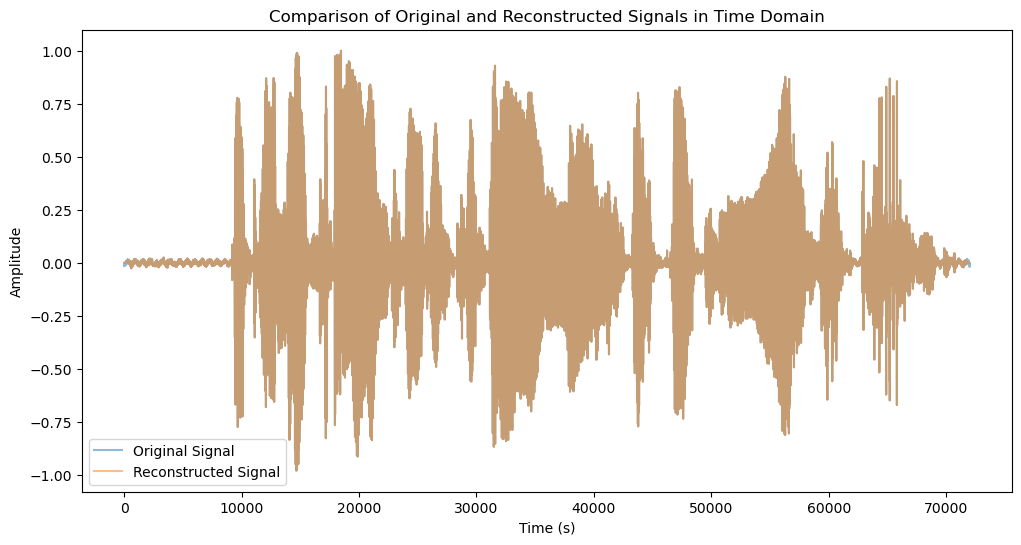

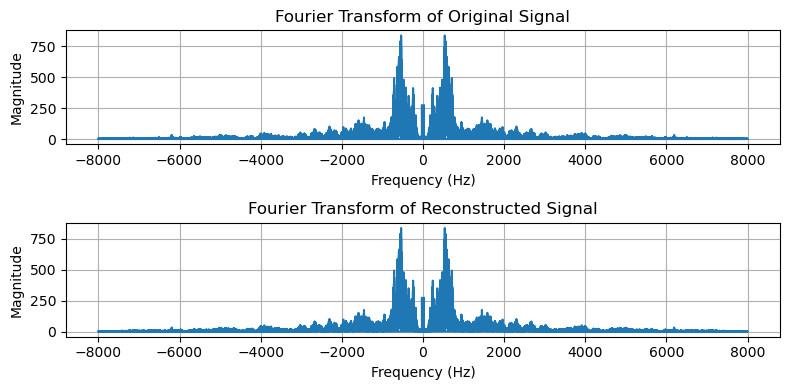

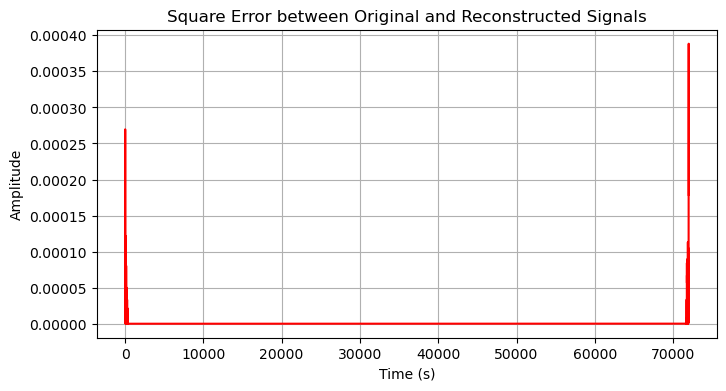

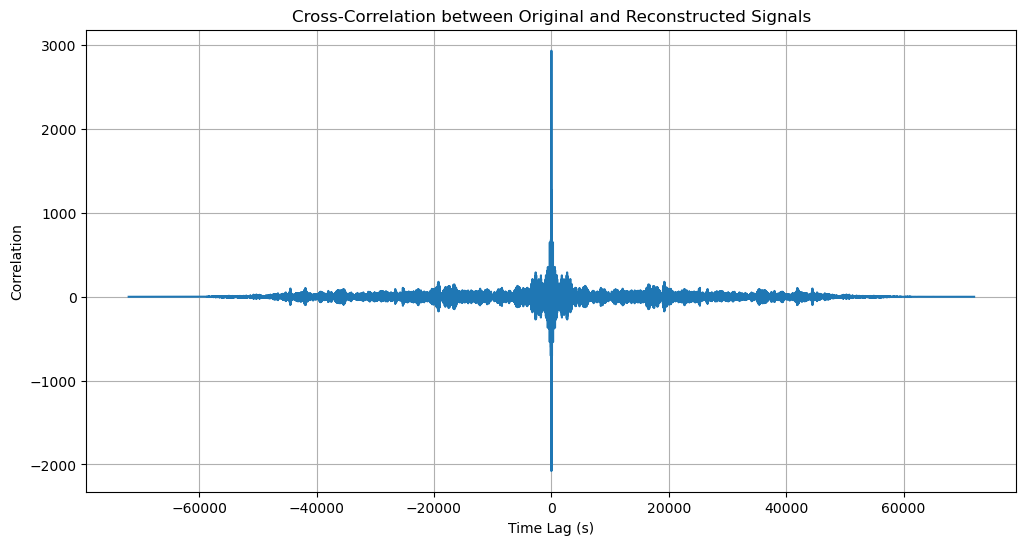

inputAudio max = 1.0 and min = -0.9807882905006409
reconstructedAudio2 max = 1.0 and min = -0.9807882308959961


In [18]:
#My clean(baseline) here being input audio and "noisy" being the simple reconstruction of it
printQualityScores(inputAudio.numpy(),reconstructedAudio2, sample_rate)

# Plot inputAudio and reconstructedAudio in the time domain
compareTwoAudios(inputAudio, torch.from_numpy(reconstructedAudio2))

print(f'inputAudio max = {np.max(inputAudio.numpy())} and min = {np.min(inputAudio.numpy())}')
print(f'reconstructedAudio2 max = {np.max(reconstructedAudio2)} and min = {np.min(reconstructedAudio2)}')

### <font color="red"> A real time simulation of audio output. Check the result with previous method</font>

- In the code; <b>myRealtimeAudioSimulator.extend(buffer[:stride_length])</b> inside the for loop shows the output of realtime audio during every ifft input
- <font color="pink"> <b> The reconstruction result is same as the previous section</b></font>

In [19]:
#512,256,128,64,32,16,8
frameSize = 512
stride_length = 32
print(f'frameSize = {frameSize} corresponds to {frameSize/sample_rate*1000} ms')
print(f'stride_length = {stride_length} corresponds to {stride_length/sample_rate*1000} ms')

frameSize = 512 corresponds to 32.0 ms
stride_length = 32 corresponds to 2.0 ms


- Get the fft frames for the entire signal, but it is just a simulation of doing fft on 1 frame per 2ms

In [20]:
slidingBuffer = np.zeros((frameSize)).astype('float32')
overlap_percent = (1 - stride_length/frameSize)*100
print(f'Overlap percentage = {overlap_percent}%')

# List of frames generated (each frame is a tensor)
framesGenerated = []

for i in range(0, len(inputAudio),stride_length):
    # print(f'i = {i}')

    #inbuffer is moved : [__s1__+++++++++++++__s2__] -> [+++++++++++++__s2__]
    slidingBuffer[:-stride_length] = slidingBuffer[stride_length:] 

    #inbuffer is filled with new data: [+++++++++++++__s2__] -> [+++++++++++++----]
    slidingBuffer[-stride_length:] = inputAudio[i : i + stride_length]
    
    # Assuming `inbuffer` is a NumPy array
    buffer_array = np.array(slidingBuffer)
    windowed_buffer = buffer_array * hann(len(buffer_array), sym=False)

    # Taking the real-valued FFT
    frame = np.fft.rfft(windowed_buffer)
    # print(f'frame shape = {frame.shape}')
    framesGenerated.append(frame)

print(f'inputAudio shape = {inputAudio.shape}')
print(f'xFrames (expectedFrames) = {len(inputAudio)//stride_length}') #Not (length - frameSize)/stride_length +1      
print(f'len(framesGenerated) = {len(framesGenerated)}')
print(f'len(framesGenerated[0]) = {framesGenerated[0].shape}')
 

Overlap percentage = 93.75%
inputAudio shape = torch.Size([72000])
xFrames (expectedFrames) = 2250
len(framesGenerated) = 2250
len(framesGenerated[0]) = (257,)


- Going into the fft frames one by one (having access to the current fft frame in time, we output 2ms of audio)

In [21]:
overlap_frames = 100 // (100-overlap_percent) - 1
print(f'Amount of future frames needed to calulate 1 frame = {overlap_frames}')

myRealtimeAudioSimulator = []

reconstructedAudioTester = np.zeros_like(inputAudio.numpy())
rtOutputBuffer = np.zeros((frameSize)).astype('float32')

#This will correspond to a "startup delay" of the system, equivalent to the frameSize
numFramesToDiscard = frameSize//stride_length - 1
for idx,frame in enumerate(framesGenerated[numFramesToDiscard:]):
    segment = np.fft.irfft(frame)
    addAtIdx = idx*stride_length
    addUntil = addAtIdx + frameSize

    # print(f'For idx = {idx}, np.add.at(reconstructedAudio2, range({addAtIdx}, {addUntil}), segment.lenth = {len(segment)})')
    np.add.at(reconstructedAudioTester, range(addAtIdx, addUntil), segment)
    
    #These indices will not have any dependency on future frames
    if(idx == len(framesGenerated[numFramesToDiscard:]) -1 ):
        myRealtimeAudioSimulator.extend(reconstructedAudioTester[addAtIdx:])
    else:
        myRealtimeAudioSimulator.extend(reconstructedAudioTester[addAtIdx:addAtIdx+stride_length])


print(f'len(myRealtimeAudioSimulator) = {len(myRealtimeAudioSimulator)}')
print(f'myRealtimeAudioSimulator[0][0].dtype = {myRealtimeAudioSimulator[0].dtype}')


Amount of future frames needed to calulate 1 frame = 15.0
len(myRealtimeAudioSimulator) = 72000
myRealtimeAudioSimulator[0][0].dtype = float32


#### Reconstruction Result for this : 

In [22]:
np_realtimeaudio = np.array(myRealtimeAudioSimulator)
np_realtimeaudio = minMaxNorm(np_realtimeaudio)
ipd.Audio(np_realtimeaudio, rate=sample_rate)

PESQ score for clean (baseline) = 4.548638343811035
PESQ score for noisy = 4.4891581535339355
---------------------------------------------------
STOI score for clean (baseline) = 0.9999999999999998
STOI score for noisy = 0.9999102732087527


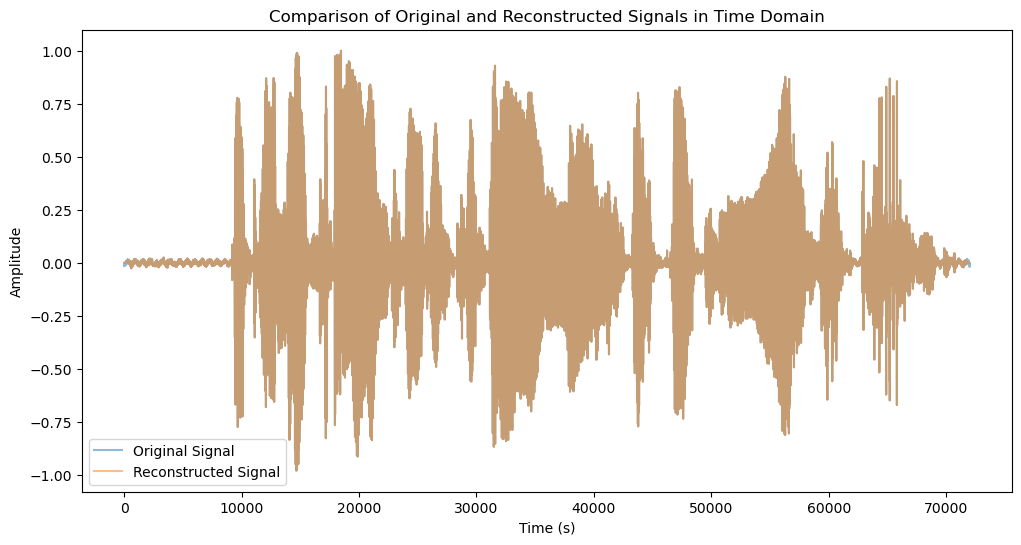

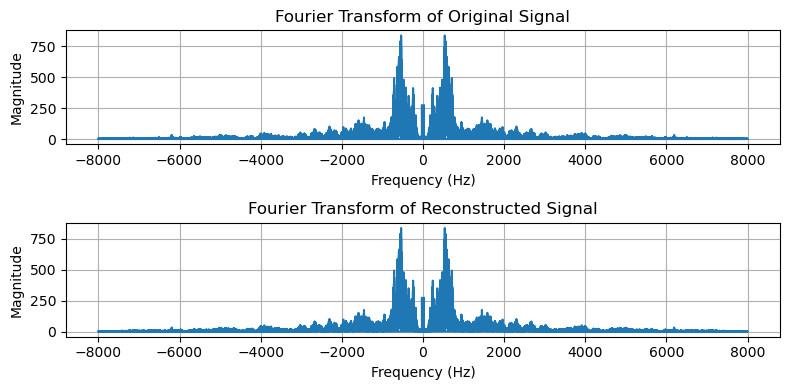

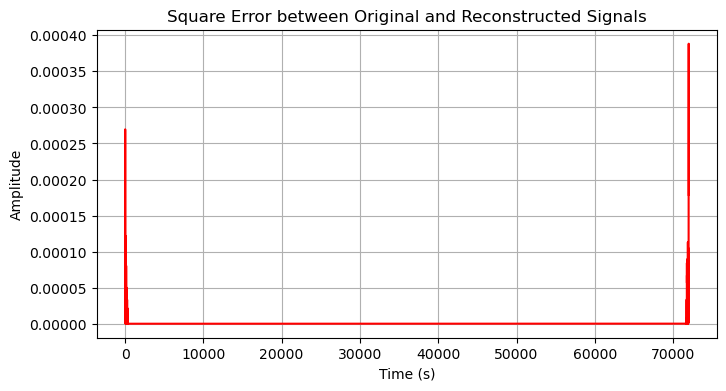

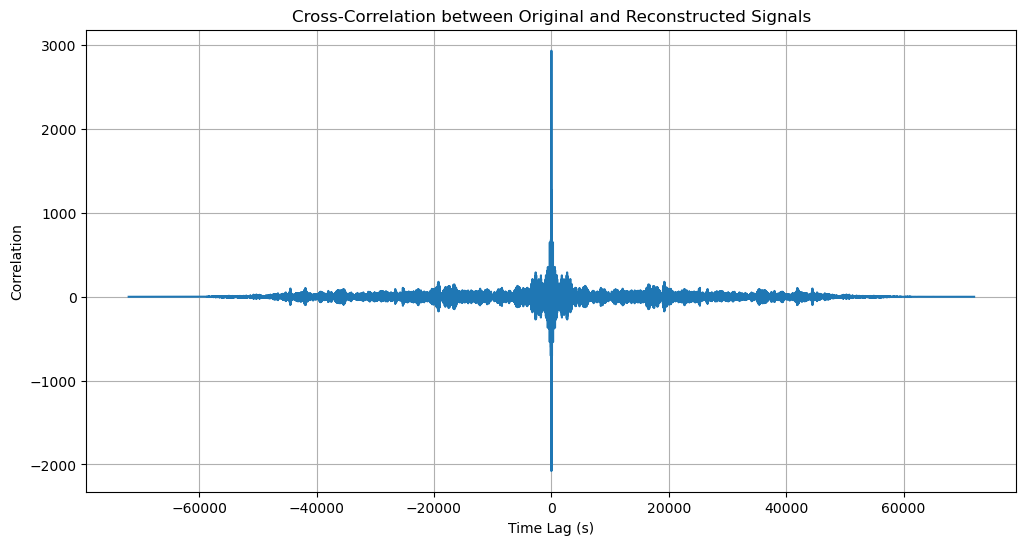

In [23]:
#My clean(baseline) here being input audio and "noisy" being the simple reconstruction of it
printQualityScores(inputAudio.numpy(),np_realtimeaudio,sample_rate)
compareTwoAudios(inputAudio, torch.from_numpy(np_realtimeaudio))


### <font color="red"> Magnitude Stuff</font>

In [24]:
#512,256,128,64,32,16,8
frameSize = 512
stride_length = 32
# stride_length = 32
print(f'frameSize = {frameSize} corresponds to {frameSize/sample_rate*1000} ms')
print(f'stride_length = {stride_length} corresponds to {stride_length/sample_rate*1000} ms')

frameSize = 512 corresponds to 32.0 ms
stride_length = 32 corresponds to 2.0 ms


In [25]:
slidingBuffer = np.zeros((frameSize)).astype('float32')
overlap_percent = (1 - stride_length/frameSize)*100
print(f'Overlap percentage = {overlap_percent}%')

# List of frames generated (each frame is a tensor)
framesGenerated = []
phaseGenerated  = []

for i in range(0, len(inputAudio),stride_length):
    # print(f'i = {i}')

    #inbuffer is moved : [__s1__+++++++++++++__s2__] -> [+++++++++++++__s2__]
    slidingBuffer[:-stride_length] = slidingBuffer[stride_length:] 

    #inbuffer is filled with new data: [+++++++++++++__s2__] -> [+++++++++++++----]
    slidingBuffer[-stride_length:] = inputAudio[i : i + stride_length]
    
    # Assuming `inbuffer` is a NumPy array
    buffer_array = np.array(slidingBuffer)
    windowed_buffer = buffer_array * hann(len(buffer_array), sym=False)

    # Taking the real-valued FFT
    frame = np.fft.rfft(windowed_buffer)
    # print(f'frame shape = {frame.shape}')
    framesGenerated.append(np.abs(frame))
    phaseGenerated.append(np.angle(frame))

print(f'inputAudio shape = {inputAudio.shape}')
print(f'xFrames (expectedFrames) = {len(inputAudio)//stride_length}') #Not (length - frameSize)/stride_length +1      
print(f'len(framesGenerated) = {len(framesGenerated)}')
print(f'len(framesGenerated[0]) = {framesGenerated[0].shape}')

Overlap percentage = 93.75%
inputAudio shape = torch.Size([72000])
xFrames (expectedFrames) = 2250
len(framesGenerated) = 2250
len(framesGenerated[0]) = (257,)


In [32]:
overlap_frames = 100 // (100-overlap_percent) - 1
print(f'Amount of future frames needed to calulate 1 frame = {overlap_frames}')

myRealtimeAudioSimulator2 = []

reconstructedAudioTester2 = np.zeros_like(inputAudio.numpy())
rtOutputBuffer = np.zeros((frameSize)).astype('float32')

#This will correspond to a "startup delay" of the system, equivalent to the frameSize
numFramesToDiscard = frameSize//stride_length - 1
for idx,frame in enumerate(framesGenerated[numFramesToDiscard:]):
    # segment = np.fft.irfft(frame)
    segment = np.fft.irfft(frame*2*np.exp(1j*phaseGenerated[numFramesToDiscard+idx]))
    addAtIdx = idx*stride_length
    addUntil = addAtIdx + frameSize

    # print(f'For idx = {idx}, np.add.at(reconstructedAudio2, range({addAtIdx}, {addUntil}), segment.lenth = {len(segment)})')
    np.add.at(reconstructedAudioTester2, range(addAtIdx, addUntil), segment)
    
    #These indices will not have any dependency on future frames
    if(idx == len(framesGenerated[numFramesToDiscard:]) -1 ):
        myRealtimeAudioSimulator2.extend(reconstructedAudioTester2[addAtIdx:])
    else:
        myRealtimeAudioSimulator2.extend(reconstructedAudioTester2[addAtIdx:addAtIdx+stride_length])


print(f'len(myRealtimeAudioSimulator) = {len(myRealtimeAudioSimulator2)}')
print(f'myRealtimeAudioSimulator[0][0].dtype = {myRealtimeAudioSimulator2[0].dtype}')


Amount of future frames needed to calulate 1 frame = 15.0
len(myRealtimeAudioSimulator) = 72000
myRealtimeAudioSimulator[0][0].dtype = float32


In [33]:
np_realtimeaudio2 = np.array(myRealtimeAudioSimulator2)
np_realtimeaudio2 = minMaxNorm(np_realtimeaudio2)
ipd.Audio(np_realtimeaudio2, rate=sample_rate)

PESQ score for clean (baseline) = 4.548638343811035
PESQ score for noisy = 4.4891581535339355
---------------------------------------------------
STOI score for clean (baseline) = 0.9999999999999998
STOI score for noisy = 0.9999102732087684


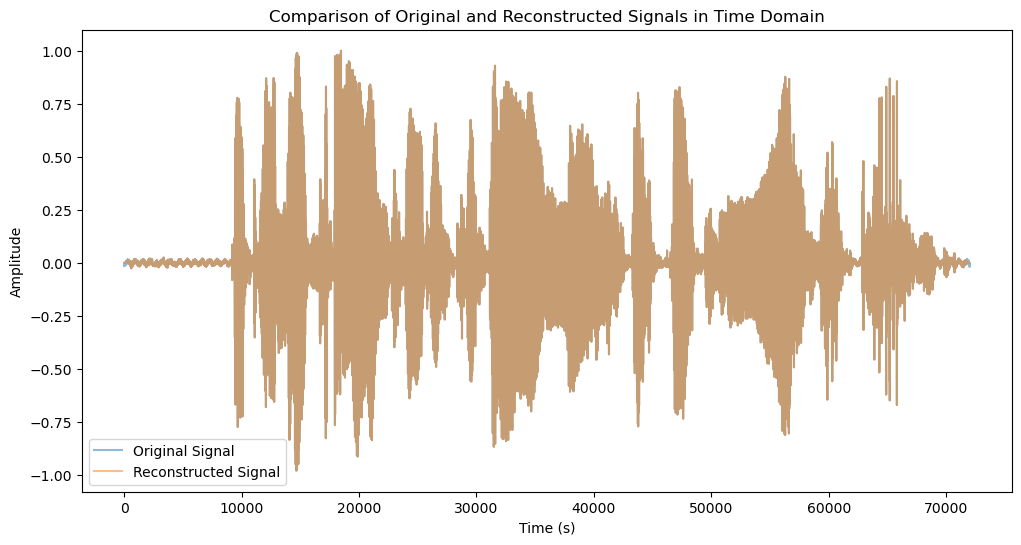

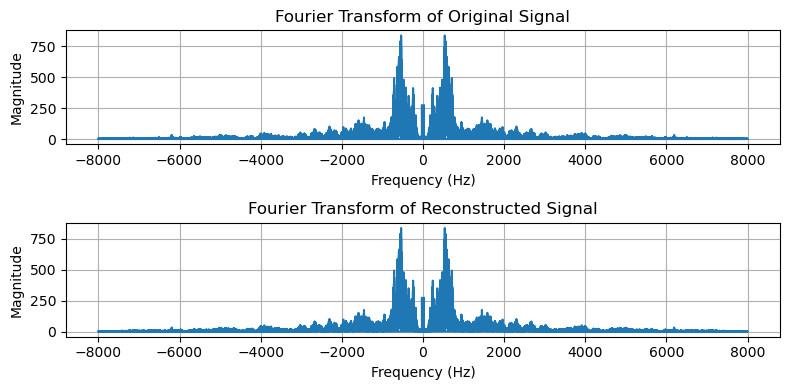

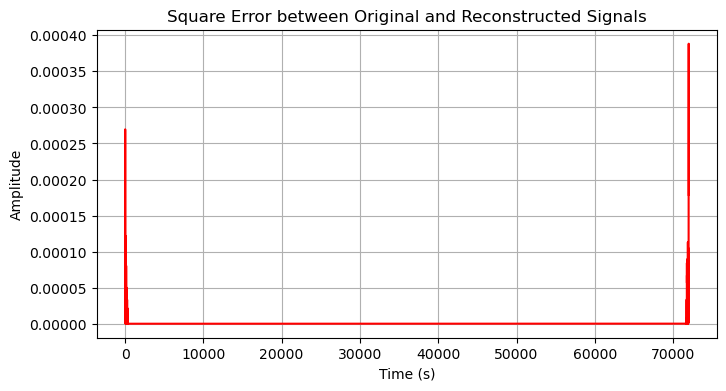

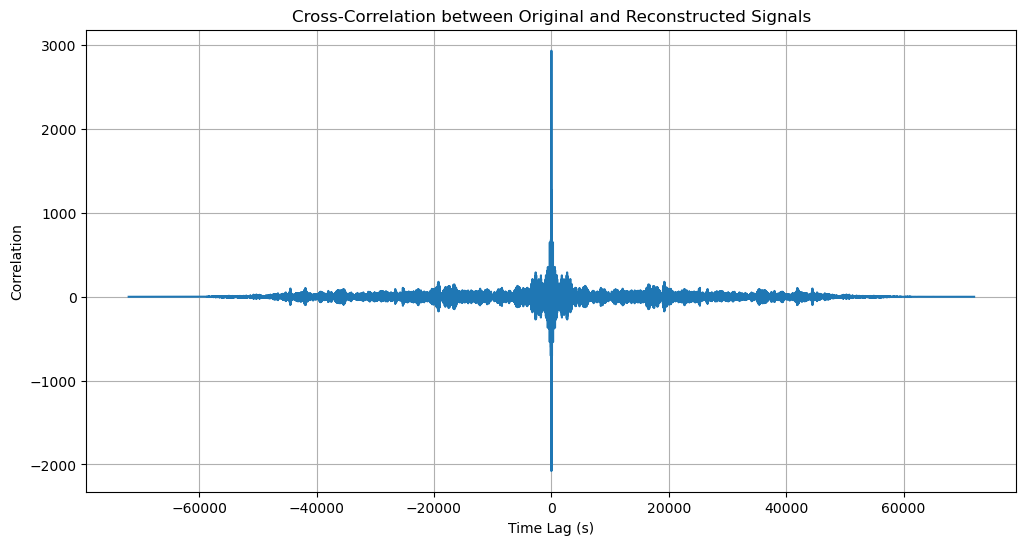

In [34]:
#My clean(baseline) here being input audio and "noisy" being the simple reconstruction of it
printQualityScores(inputAudio.numpy(),np_realtimeaudio2,sample_rate)
compareTwoAudios(inputAudio, torch.from_numpy(np_realtimeaudio2))
